# Coverage depth analysis

In [1]:
import pandas as pd
from common import *

prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 1)
oxbs_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1)
tab_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1)

all_raw = pd.merge(tab_raw, oxbs_raw, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_oxBS"]).merge(
    prom_raw, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Prom"])
    
readcounts_only = all_raw.drop(columns=["percentMeth_5hmC_Bisulphite", "percentMeth_5mC_Bisulphite", "strand", "percentMeth_C", "percentMeth_5mC_Prom", "percentMeth_5hmC_Prom"]).rename(columns={
    "readCount" : "readCount_Nanopore"
})

from pyranges import PyRanges
import MultisiteTools

readcount_features = PyRanges(changeColNamesForPR(readcounts_only)).join(MultisiteTools.featureRefPyRange(), strandedness=False, slack=0)
readcount_features_df = readcount_features.as_df().melt(id_vars=["Chromosome", "Start", "End", "feature_type"], 
                                                        value_vars=["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"], 
                                                        value_name="readCount",
                                                        var_name="Method")

<Axes: xlabel='feature_type', ylabel='readCount'>

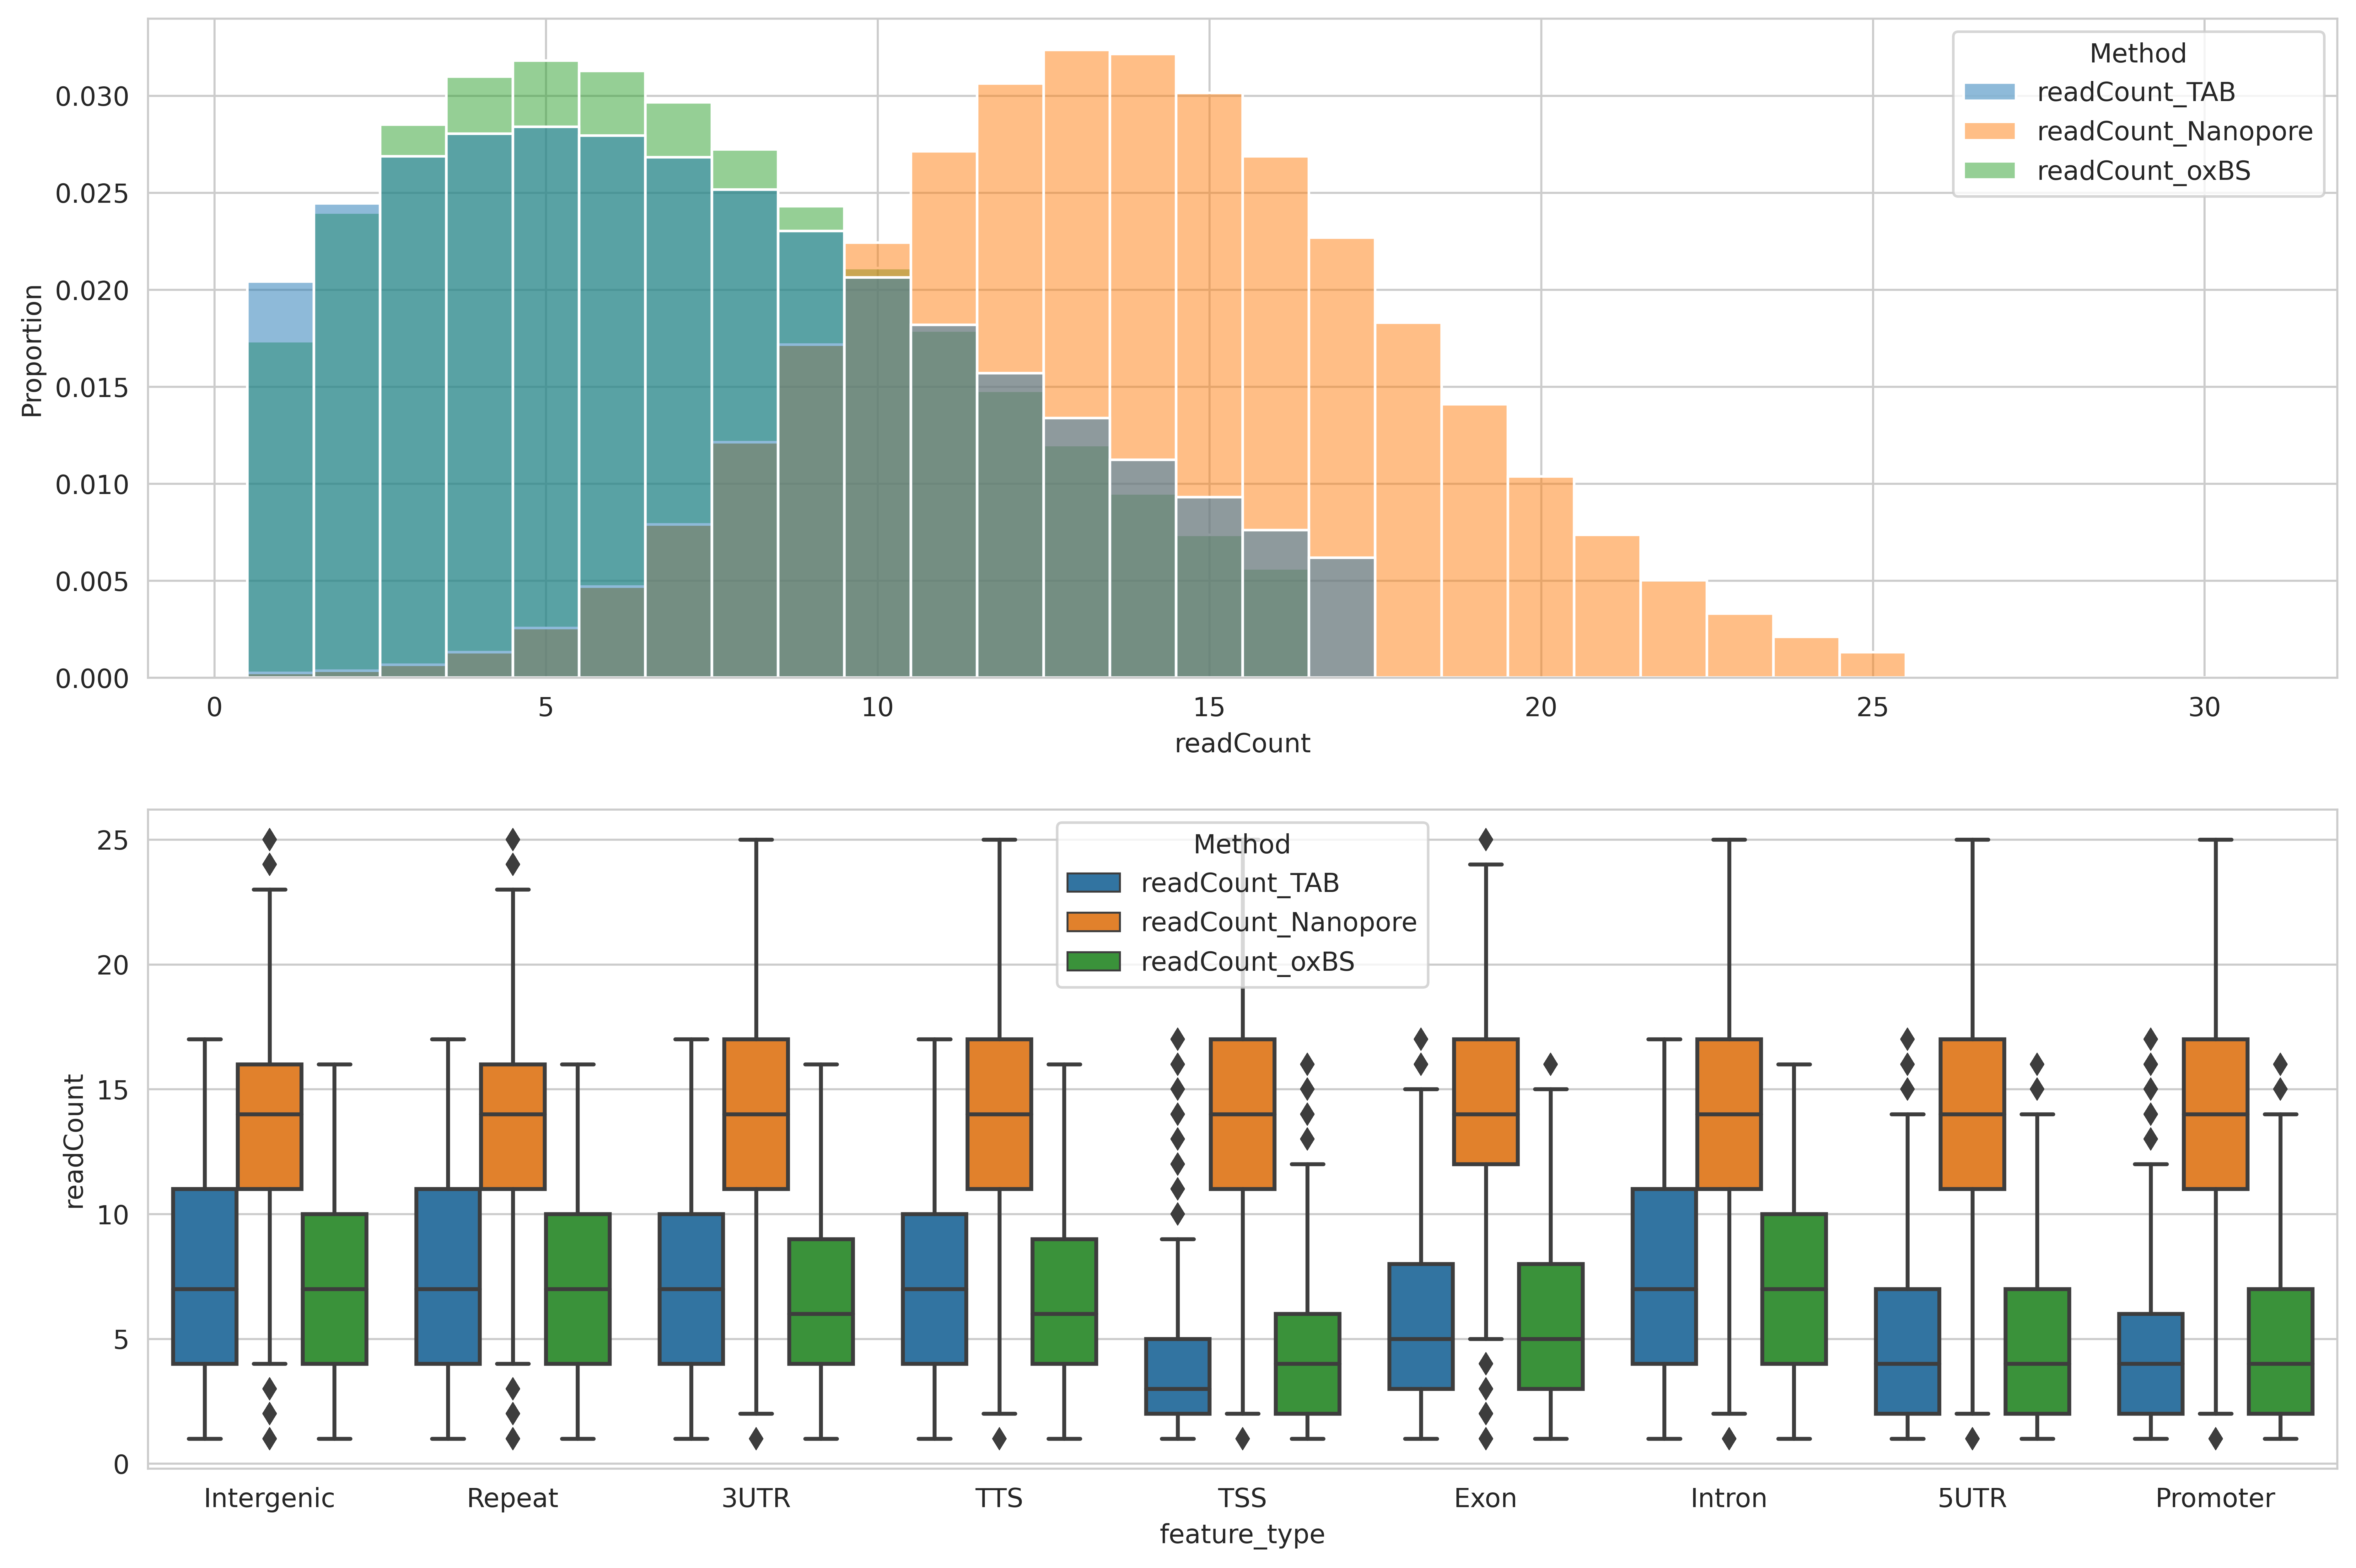

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(15, 10), dpi=600)

sns.histplot(readcount_features_df, x="readCount", stat="proportion", hue="Method", discrete=True, binwidth=1, binrange=(1, 30), ax=axes[0])
sns.boxplot(readcount_features_df, x="feature_type", y="readCount", hue="Method", dodge=True, ax=axes[1])

# CpG level comparison

## Raw data processing

In [1]:
import common 
import pandas as pd

if not "prom_comp_data" in locals().keys(): 
    nanopore_threemod_prom = common.readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 
                                                   10, apply_max_depth=True)

    oxbs_df = common.readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", 
                                "5mC", min_depth=10, apply_max_depth=True)

    tab_df = common.readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov",
                                    "5hmC", min_depth=10, apply_max_depth=True)
    
    bis_all = tab_df.merge(oxbs_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_oxBS"])

    prom_comp_data = nanopore_threemod_prom.merge(bis_all, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_Bisulphite"])

In [11]:
prom_comp_data.to_csv("./data_tables/prom_comp_data_10x_wDepthFilt.tsv", index=False)

In [2]:
import common 
import pandas as pd

prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

## Similarities

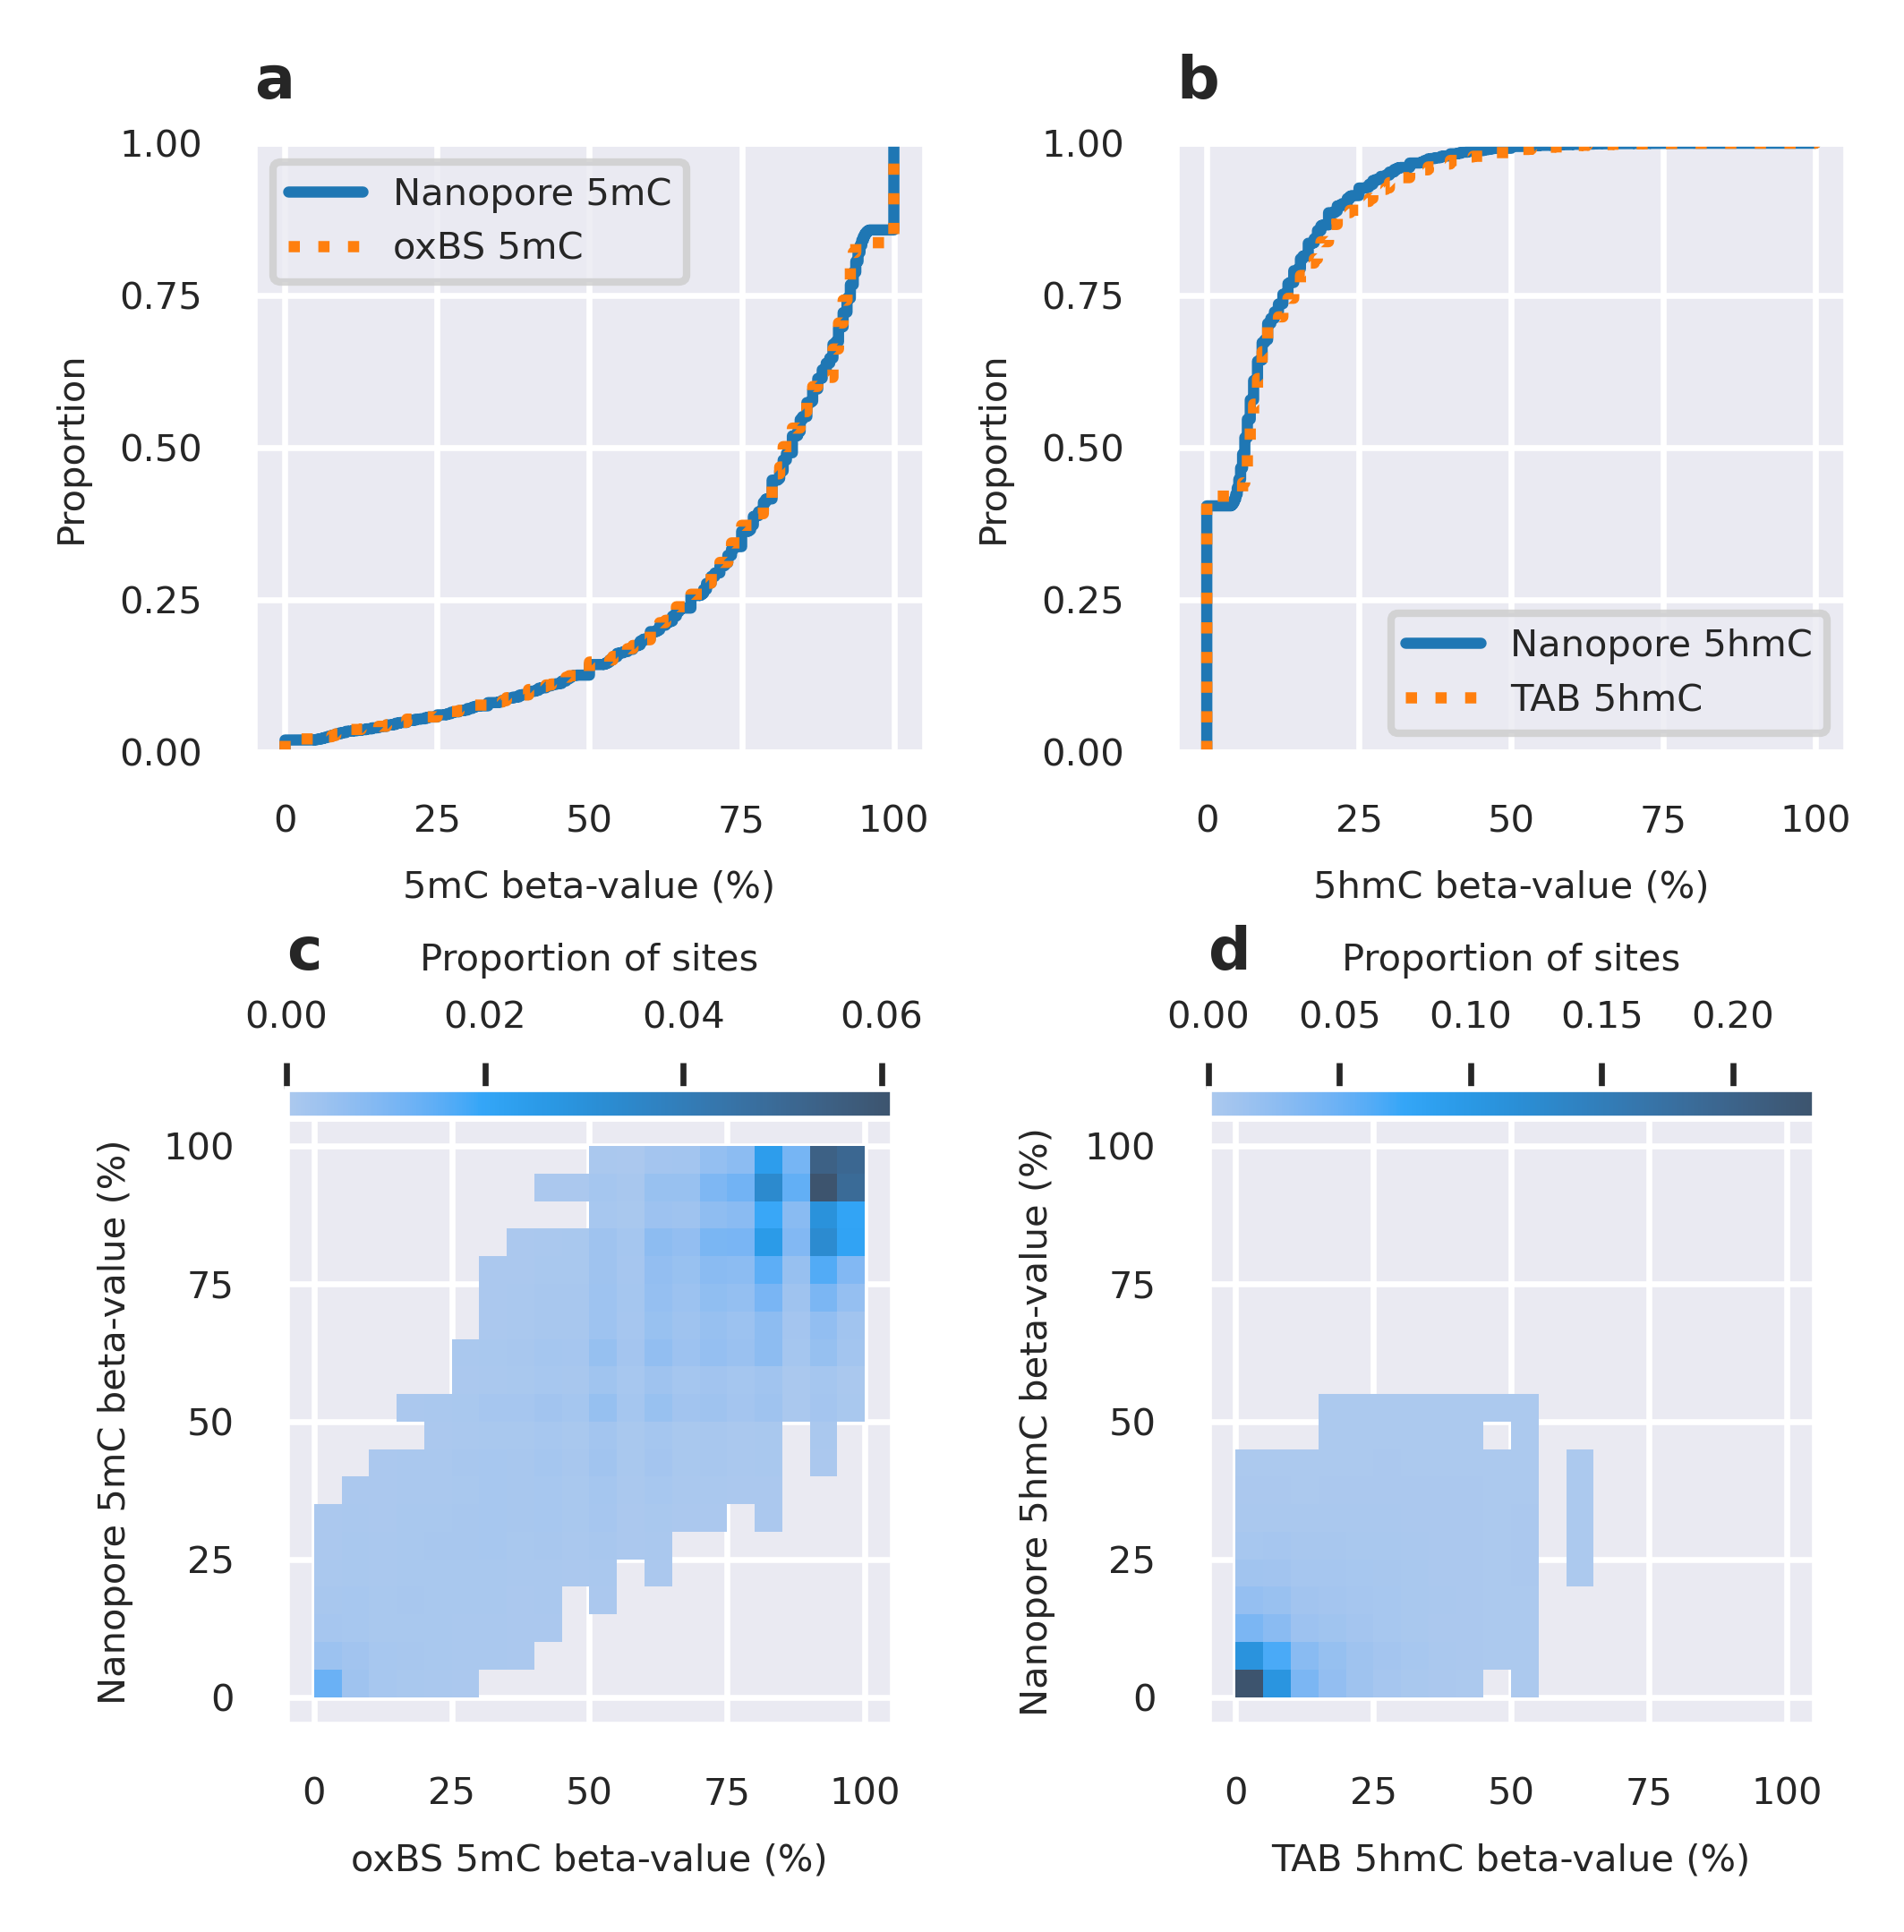

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

plt.figure(figsize=(89/25.4, 89/25.4), dpi=600)

sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]
legends = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

for index, ax in enumerate([ax1, ax2]):
    sns.ecdfplot(prom_comp_data.melt(
            id_vars=["chromosome", "chromStart", "chromEnd"], 
            value_vars=comparison[index], var_name="method", value_name="percentMeth").query(f"method == '{comparison[index][0]}'"),
        x="percentMeth", ls="-", label=legends[index][0], color=sns.color_palette()[0], ax=ax)
    
    sns.ecdfplot(prom_comp_data.melt(
            id_vars=["chromosome", "chromStart", "chromEnd"], 
            value_vars=comparison[index], var_name="method", value_name="percentMeth").query(f"method == '{comparison[index][1]}'"),
        x="percentMeth", ls=":", label=legends[index][1], color=sns.color_palette()[1], ax=ax)

    ax.set_aspect(100)
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 1.25, 0.25))

ax1.set_xlabel("5mC beta-value (%)")
ax1.legend(labels=legends[0], title=None, loc="upper left")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("5hmC beta-value (%)")
ax2.legend(labels=legends[1], title=None, loc="lower right")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

for index, ax in enumerate([ax3, ax4]):
    div = make_axes_locatable(ax)
    cax = div.append_axes("top", size="5%", pad=0)
    sns.histplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 stat="proportion", binwidth=5, pthresh=0.01, cbar=True, 
                 cbar_kws={"label" : "Proportion of sites",
                           "orientation" : "horizontal",
                           "location" : "top"
                           }, 
                 ax=ax, cbar_ax=cax)
    ax.set_aspect("equal")
    ax.set_yticks(np.arange(0, 125, 25))
    ax.set_xticks(np.arange(0, 125, 25))

ax3.set_xlabel("oxBS 5mC beta-value (%)")
ax3.set_ylabel("Nanopore 5mC beta-value (%)")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold", pad=20)

ax4.set_xlabel("TAB 5hmC beta-value (%)")
ax4.set_ylabel("Nanopore 5hmC beta-value (%)")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold", pad=20)

plt.gcf().set_size_inches(89/25.4, 89/25.4)
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_sim.png", dpi=600)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]

for comp in comparison:
    x = prom_comp_data[comp[1]].to_numpy().reshape(-1, 1)
    y = prom_comp_data[comp[0]].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Model for {comp[0]} ~ {comp[1]}: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

Model for percentMeth_5mC_Nanopore ~ percentMeth_5mC_Bisulphite: 15.79 + 0.793X; R²=0.639
Model for percentMeth_5hmC_Nanopore ~ percentMeth_5hmC_Bisulphite: 4.422 + 0.435X; R²=0.241


## Differences

In [ ]:
prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

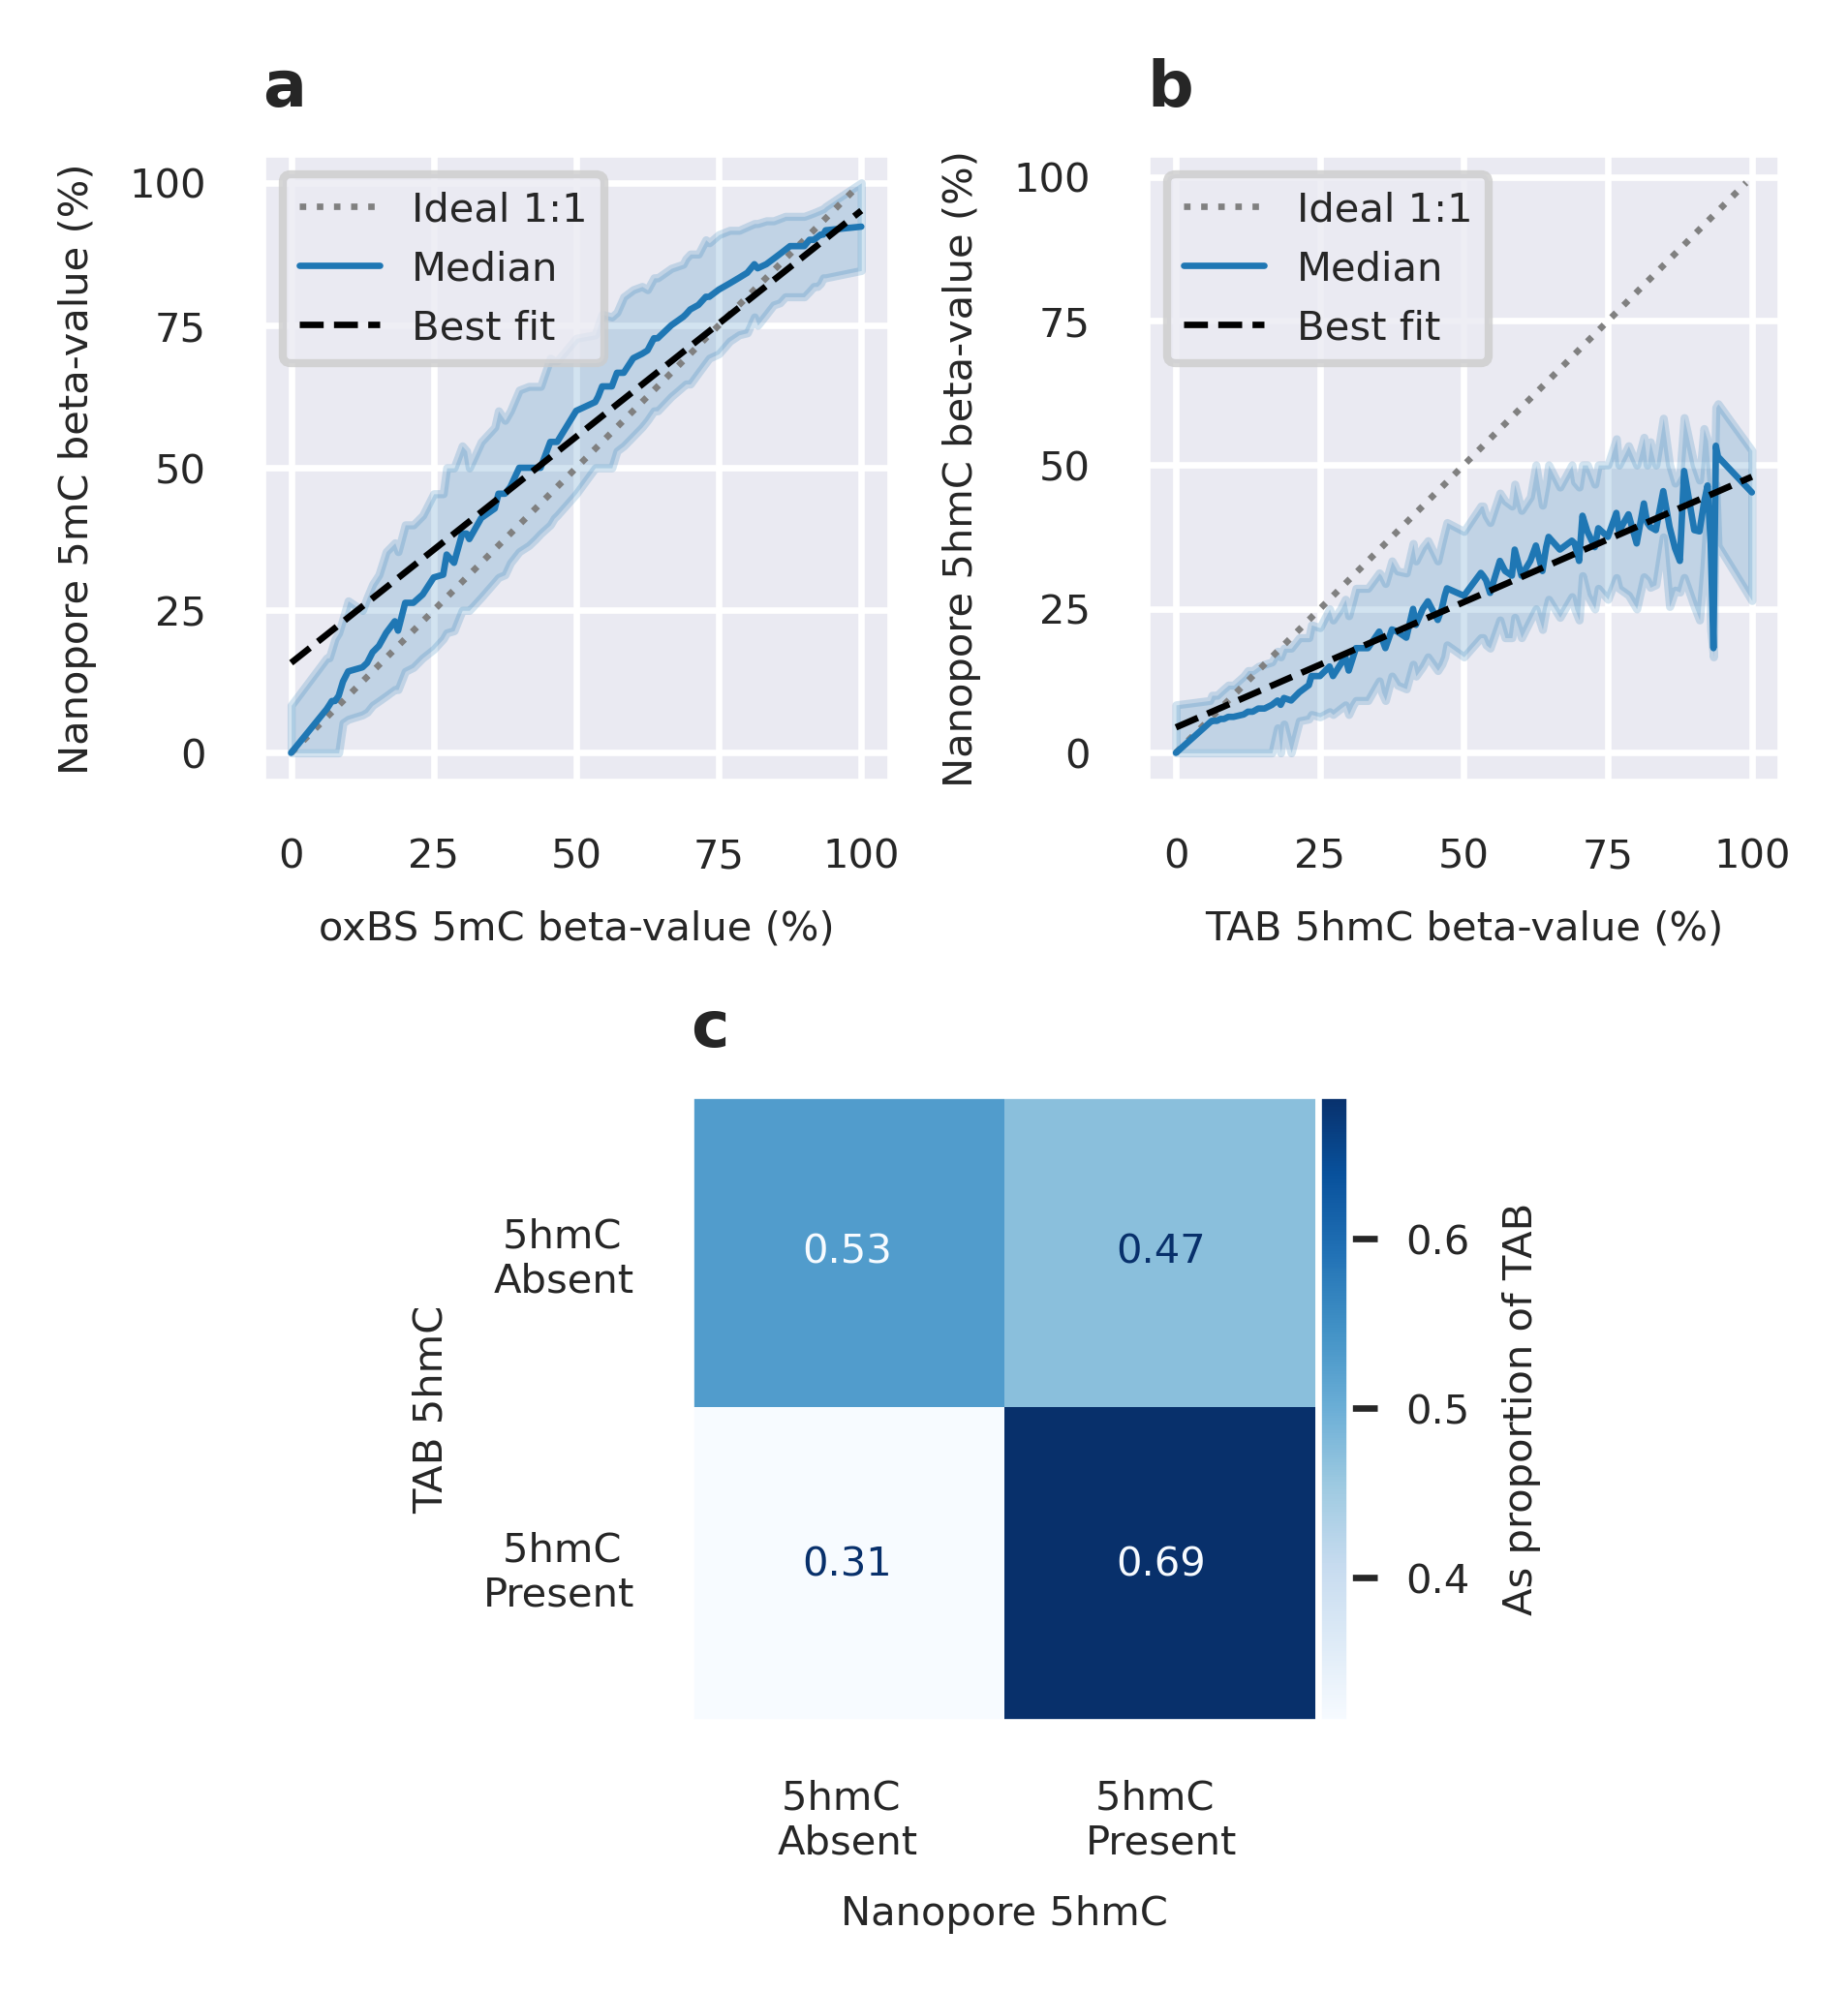

In [58]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import Binarizer
from sklearn import metrics
from cycler import cycler

plt.figure(figsize=(89/25.4, 89/25.4), dpi=600)

sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 4), (1, 1), colspan=2)

##### Row 1 #####
# Panel 1 and 2 # 

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]

for index, ax in enumerate([ax1, ax2]):
    ax.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", lw=0.8, label="Ideal 1:1")
    sns.lineplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 label="Median", estimator='median', errorbar=("pi", 50), lw=0.8, ax=ax)
    sns.regplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 ci=None, color="black", line_kws={
                    "ls" : "--",
                    "lw" : 0.8
                    }, label="Best fit", scatter=False, ax=ax)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 125, 25))
    ax.legend()

ax1.set_xlabel("oxBS 5mC beta-value (%)")
ax1.set_ylabel("Nanopore 5mC beta-value (%)")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("TAB 5hmC beta-value (%)")
ax2.set_ylabel("Nanopore 5hmC beta-value (%)")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

##### Row 2 #####
# Panel 3 # 

div = make_axes_locatable(ax3)
cax = div.append_axes("right", size="5%", pad=0)

true, pred = prom_comp_data["percentMeth_5hmC_Bisulphite"].to_numpy().reshape((-1, 1)), prom_comp_data["percentMeth_5hmC_Nanopore"].to_numpy().reshape((-1, 1))

binarizer = Binarizer(threshold=0)
true_b, pred_b = binarizer.fit_transform(true), binarizer.fit_transform(pred)
cm = metrics.ConfusionMatrixDisplay.from_predictions(
    true_b, pred_b, 
    display_labels=["5hmC \nAbsent", "5hmC \nPresent"], 
    normalize="true", 
    colorbar=False, cmap="Blues", 
    im_kw={"origin" : "lower"}, 
    values_format=".2f",
    ax=ax3)

plt.colorbar(cm.im_, cax, label="As proportion of TAB")
ax3.grid(False)
ax3.set_xlabel("Nanopore 5hmC")
ax3.set_ylabel("TAB 5hmC")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

plt.gcf().set_size_inches(89/25.4, 89/25.4)
plt.subplots_adjust(wspace=0.8, hspace=0.5)
# plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_dif.png", dpi=600)

# Macro-level 5hmC comparison

In [1]:
import pandas as pd
from MultisiteTools import *

prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

# renaming columns for compatability with PyRanges
prom_comp_data = prom_comp_data.rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start",
    "chromEnd" : "End"})

prom_comp_pr = CpGRange(prom_comp_data).unstrand()

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_comp_pr.group_by_annotation("features", "./feature_references/genic/").enrichment_over_mean(include_zeros=True).df
    all_cgi = prom_comp_pr.group_by_annotation("CGI", "./feature_references/cgi/").enrichment_over_mean(include_zeros=True).df
    all_genes = prom_comp_pr.group_by_annotation("genes", "./feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean(include_zeros=True).df
    # tiles = prom_comp_pr.group_by_tile(1000).enrichment_over_mean(include_zeros=True).df

In [3]:
def annotationPivot(df):
    pivoted_df = pd.wide_to_long(df, 
        stubnames=["percentMeth_5mC", "log2enrichment_5mC", "percentMeth_5hmC", "log2enrichment_5hmC"], 
        i=["Name", "feature_type", "Start", "End"], 
        j="method", sep="_", suffix="\D+")
    return pivoted_df.reset_index()

In [4]:
all_features_df, all_cgi_df = map(annotationPivot, [all_features, all_cgi])

In [5]:
all_features_df["feature_type"] = pd.Categorical(all_features_df["feature_type"], 
                                              ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])

all_cgi_df["feature_type"] = pd.Categorical(all_cgi_df["feature_type"], 
                                         ["Shelf", "Shore", "CGI"])


## Figure

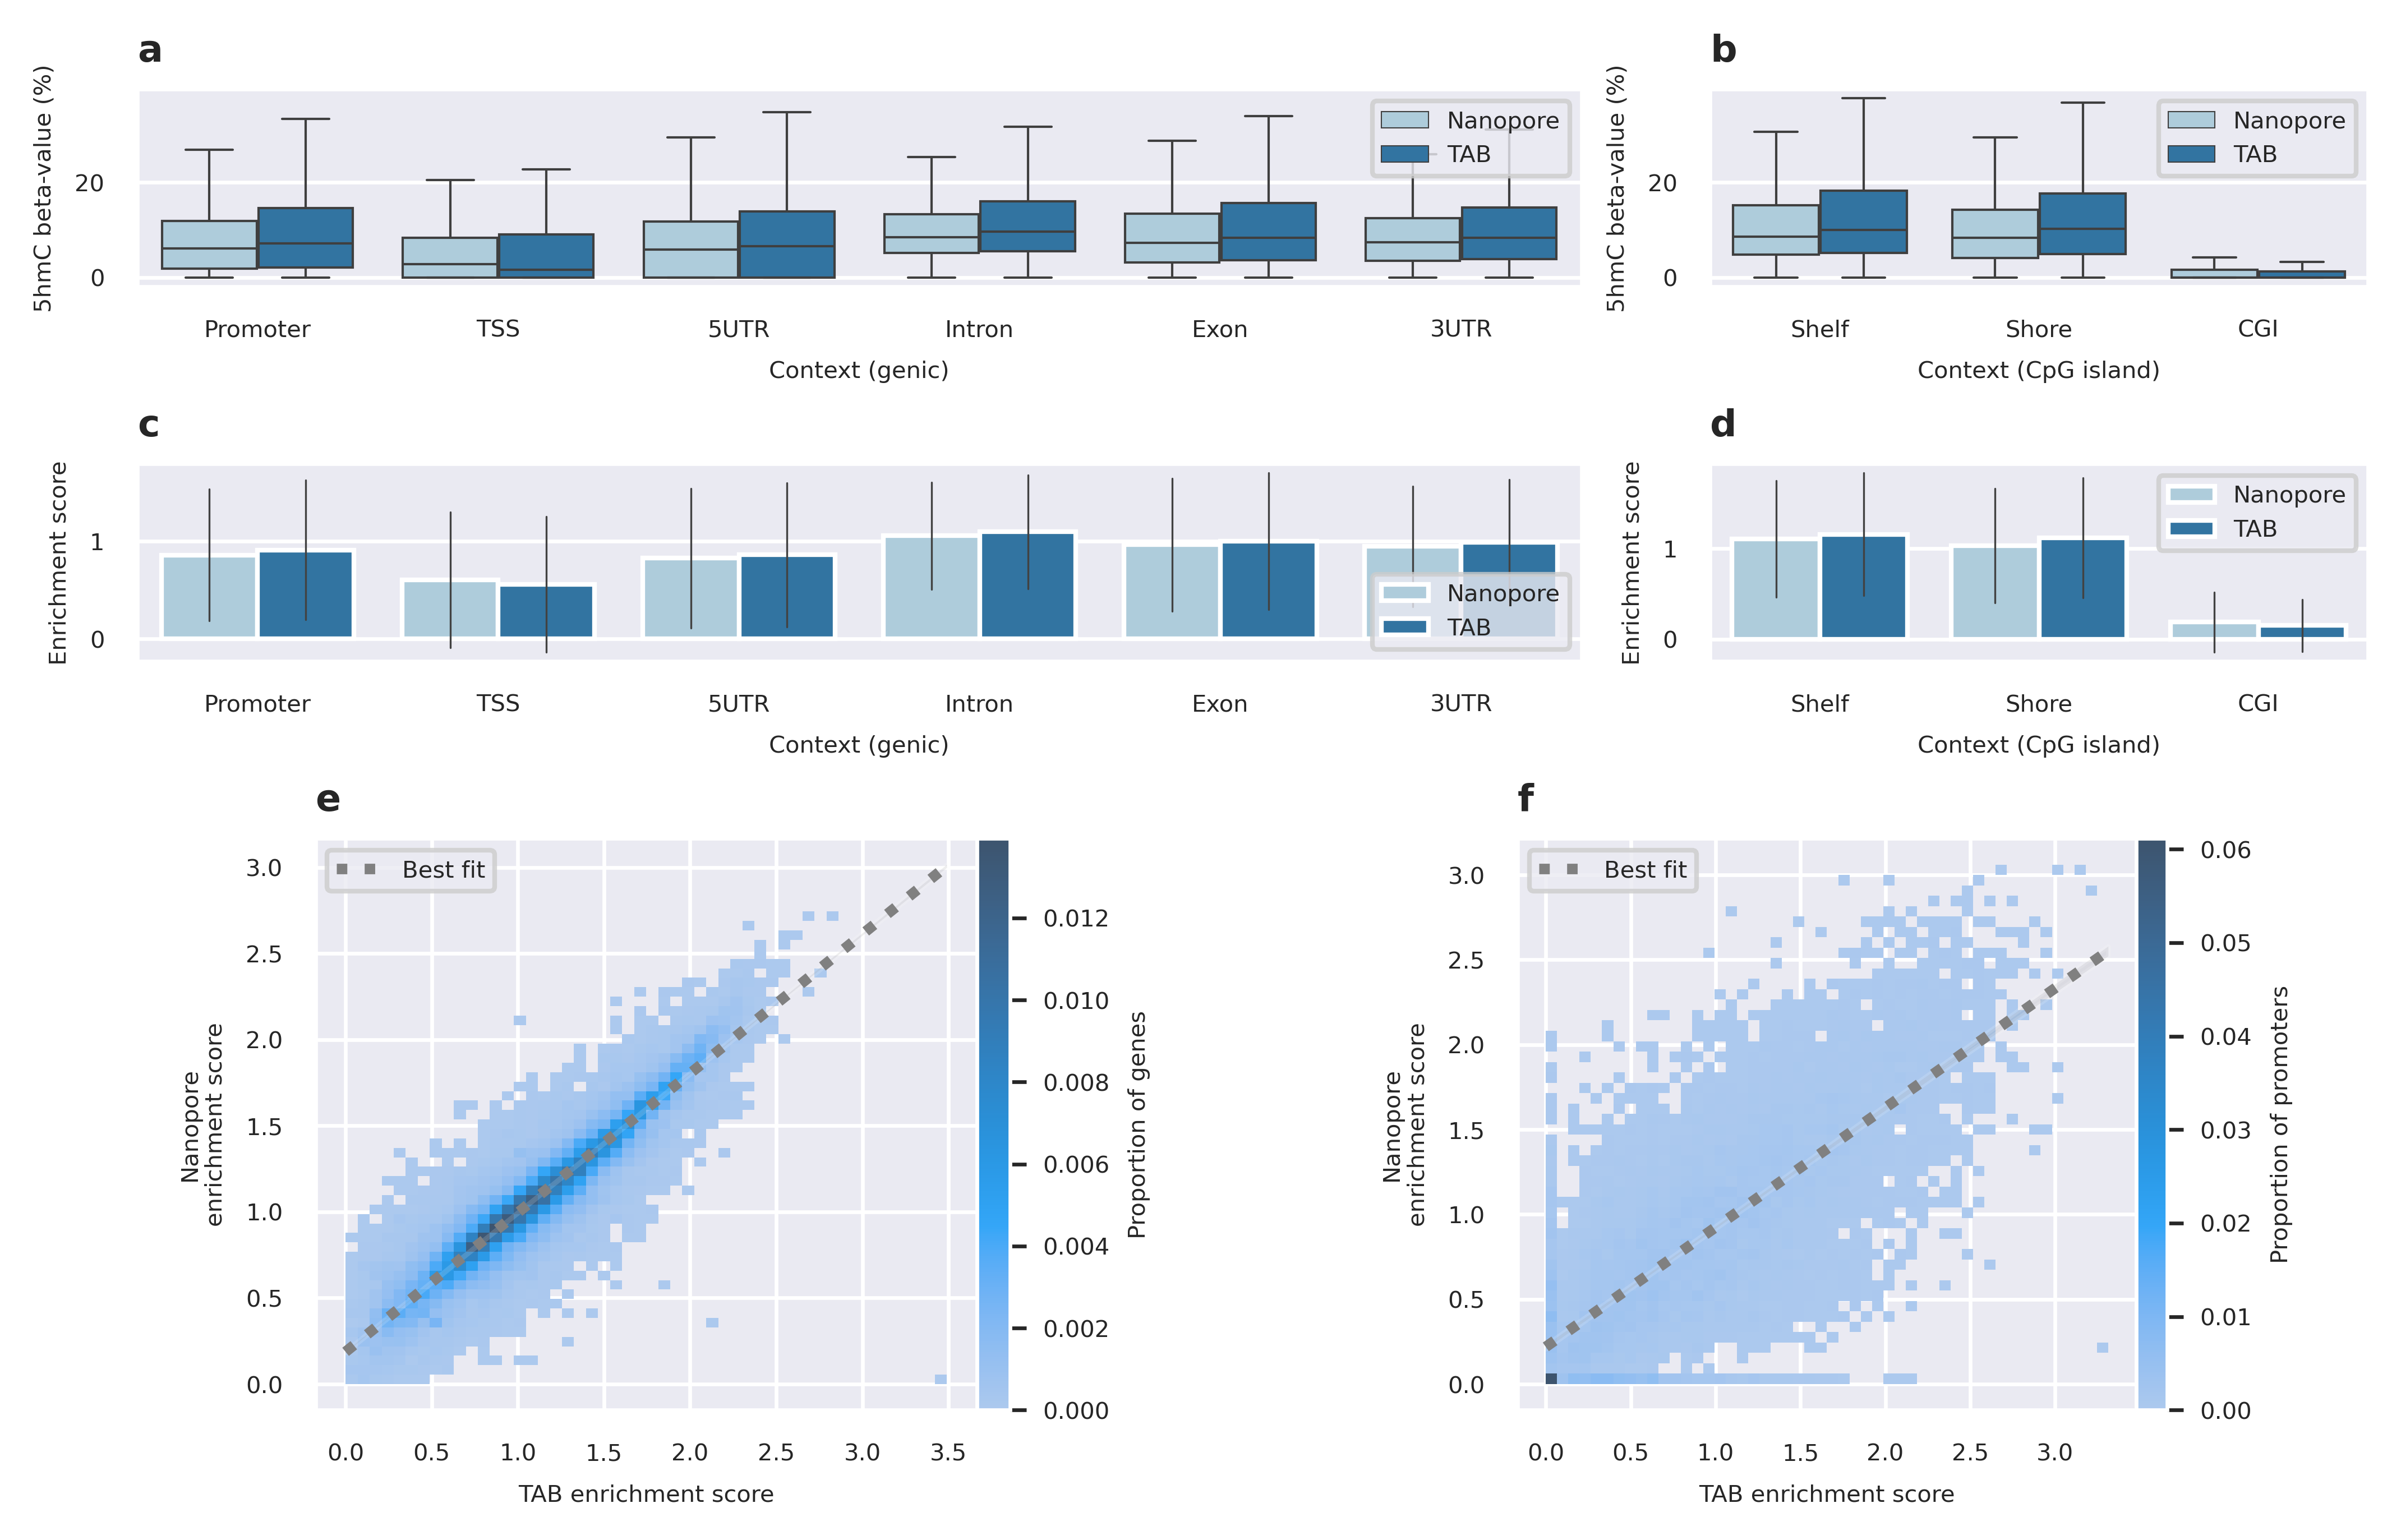

In [16]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((4, 6), (0, 0), colspan=4)
ax2 = plt.subplot2grid((4, 6), (0, 4), colspan=2)
ax3 = plt.subplot2grid((4, 6), (1, 0), colspan=4)
ax4 = plt.subplot2grid((4, 6), (1, 4), colspan=2)
ax5 = plt.subplot2grid((4, 6), (2, 0), colspan=3, rowspan=2)
ax6 = plt.subplot2grid((4, 6), (2, 3), colspan=3, rowspan=2)

all_features_df = all_features_df.replace("Bisulphite", "TAB")
all_cgi_df = all_cgi_df.replace("Bisulphite", "TAB")

# Panel 1 # 
# sns.violinplot(all_features_df.query("Name != 'Intergenic'"), x="feature_type", y="percentMeth_5hmC", scale="width", hue="method", cut=0, linewidth=0.3, palette="Paired", ax=ax1)
sns.boxplot(all_features_df, x="feature_type", y="percentMeth_5hmC", 
            hue="method", linewidth=0.5, palette="Paired", showfliers=False, ax=ax1)
ax1.set_ylabel("5hmC beta-value (%)")
ax1.set_xlabel("Context (genic)")
ax1.legend(title=None, loc="upper right")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax1.sharey(ax2)

# Panel 2 # 

# sns.violinplot(all_cgi_df.query("Name != 'Open sea'"), x="feature_type", y="percentMeth_5hmC", scale="width", hue="method", cut=0, linewidth=0.3, palette="Paired", ax=ax2)
sns.boxplot(all_cgi_df, x="feature_type", y="percentMeth_5hmC", 
            hue="method", linewidth=0.5, palette="Paired", showfliers=False, ax=ax2)
ax2.set_ylabel("5hmC beta-value (%)")
ax2.set_xlabel("Context (CpG island)")
ax2.legend(title=None, loc="upper right")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

# Panel 3 # 
sns.barplot(all_features_df.query("Name != 'Intergenic' & log2enrichment_5hmC != -inf"), x="feature_type", y="log2enrichment_5hmC", 
            hue="method", palette="Paired", errwidth=0.4, errorbar=("sd", 1), ax=ax3)
ax3.set_ylabel(f"Enrichment score")
ax3.tick_params("x", labelrotation=0, direction="out")
ax3.set_xlabel("Context (genic)")
ax3.legend(title=None, loc="lower right")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 #
sns.barplot(all_cgi_df.query("Name != 'Open sea' & log2enrichment_5hmC != -inf"), x="feature_type", y="log2enrichment_5hmC", 
            hue="method", palette="Paired", errwidth=0.4, errorbar=("sd", 1), ax=ax4)
ax4.set_ylabel(f"Enrichment score")
ax4.tick_params("x", labelrotation=0, direction="out")
ax4.set_xlabel("Context (CpG island)")
ax4.legend(title=None, loc="upper right")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

plt.subplots_adjust(wspace=0.2, hspace=0.6)

# Panel 5 # 
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("right", size="5%", pad=0)

sns.histplot(all_genes.query("CpG_count >= 10"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             stat="proportion", cbar=True, cbar_ax=cax5, cbar_kws={"label" : "Proportion of genes"}, bins=50, ax=ax5)
sns.regplot(all_genes.query("CpG_count >= 10"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", scatter=False, line_kws={"color" : "grey", "ls" : ":"}, label="Best fit", ax=ax5)
ax5.set_title("e", loc="left", fontsize=8, fontweight="bold")

# Panel 6 # 
div6 =  make_axes_locatable(ax6)
cax6 = div6.append_axes("right", size="5%", pad=0)

sns.histplot(all_features.query("CpG_count >=2 & feature_type == 'Promoter'"), 
             x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             stat="proportion", cbar=True, cbar_ax=cax6, cbar_kws={"label" : "Proportion of promoters"}, bins=50, ax=ax6)
sns.regplot(all_features.query("CpG_count >=2 & feature_type == 'Promoter'"), 
            x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", scatter=False, line_kws={"color" : "grey", "ls" : ":"}, label="Best fit", ax=ax6)
# sns.histplot(tiles.query("CpG_count > 3"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", stat="count", cbar=True, cbar_ax=cax6, cbar_kws={"label" : "Count (windows)"}, bins=50, ax=ax6)
# sns.regplot(tiles.query("CpG_count > 3"), x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", scatter=False, line_kws={"color" : "grey", "ls" : ":"}, label="Best fit", ax=ax6)
ax6.set_title("f", loc="left", fontsize=8, fontweight="bold")

for ax in [ax5, ax6]:
    ax.set_xlabel("TAB enrichment score")
    ax.set_ylabel("Nanopore\nenrichment score")
    # ax.set_ylim(0, 3.25)
    # ax.set_xlim(0, 3.25)
    ax.set_aspect("equal")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.gcf().set_size_inches(180/25.4, 115/25.4)
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level.png", dpi=600)

In [24]:
all_features.query("feature_type == 'Promoter'")["CpG_count"].quantile(0.234)

2.0

In [14]:
all_genes["CpG_count"].quantile(0.25)

10.0

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

comparison =[all_genes.query("CpG_count >= 10"), all_features.query("CpG_count >= 2 & feature_type == 'Promoter'")]

for comp in comparison:
    x = comp["log2enrichment_5hmC_Bisulphite"].to_numpy().reshape(-1, 1)
    y = comp["log2enrichment_5hmC_Nanopore"].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Model: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

Model: 0.187 + 0.808X; R²=0.865
Model: 0.182 + 0.743X; R²=0.634


# Novelties in NGS 5hmC sequencing
Here I will show features that make NGS sequencing, in particular nanopore long reads, unique in the context of 5hmC sequencing - namely the ability to directly contextualise 5hmC in the differentially methylated regions of imprinted genes, and the sensitivity of the sequencer to low input 5hmC-enriched DNA. 

In [1]:
import pandas as pd
import ImprintPhasing
import ModBamTools 

read_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam"
dmr_path = "./feature_references/dmr/mm39_dmr_coordinates.bed"

dmr_regions = pd.read_csv(dmr_path, names=["Chromosome", "Start", "End", "Name", "PofO"], sep="\t").to_dict("index")

In [2]:
all_dmr_df = ModBamTools.CpGsFromModbam("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam", dmr_regions)

Note - Not clear what `refPos = -1` could refer to. These may be InDels, or may refer to CpG positions falling outside of the query region defined by `bam.reads()`

Note readID: `45d44977-2e22-404a-8683-d07facf254eb` appears to pass through two DMR (Nespas-Gnasxl and Gnas) loci - it is methylated in the Gnas DMR and hypomethylated in the Nespas-Gnasxl DMR. Gnas is paternally expressed (maternally imprinted), and GeneImprint notes that Nespas-Gnasxl is expressed depending on isoform variant. 

Visualise how each set of phased reads looks using a clustermap. Cluster 1 in `phased_reads` is the methylated allele. Cluster 2 is the unmethylated allele. 

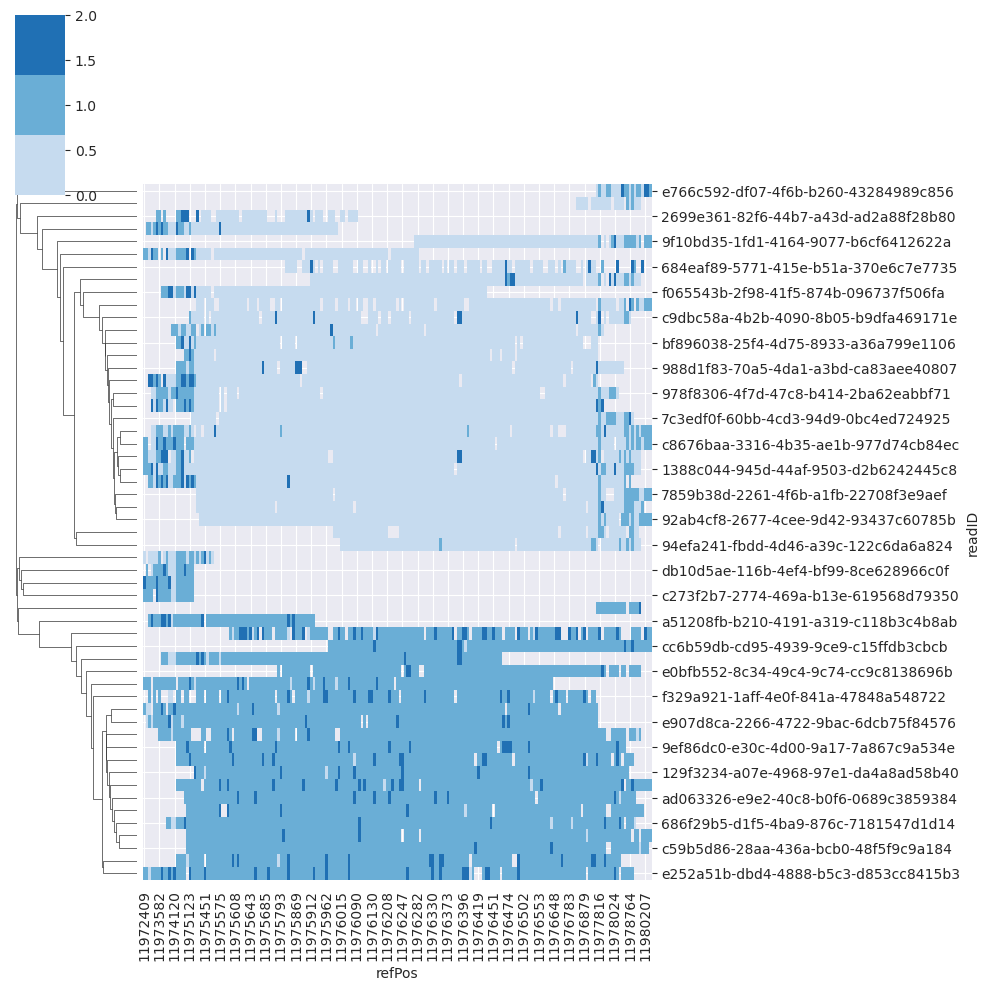

In [3]:
import seaborn as sns

sns.set_style("darkgrid")

all_dmr_df.read_matrix(10, 10, "Grb10").demo_clustermap()
# all_dmr_df.read_matrix(20, 20, "Nespas-Gnasxl").demo_phased_reads_as_df()["Cluster"].value_counts()

# Gnas1A_clusters = all_dmr_df.read_matrix(40, 30, "Gnas1A").demo_phased_reads_as_df() 

In [4]:
all_dmr_df.read_matrix(20, 20, "Nespas-Gnasxl").output_readIDs("Nespas-Gnasxl")

In [37]:
bar_df = all_dmr_df.read_matrix(20, 20, "Nespas-Gnasxl").as_modDF(all_dmr_df, merge_sites=False).replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

We now have the readIDs/fragments present within each allele. Within Nespas-Gnasxl there are 39 reads with approx. 98 CpG sites. Note that this can be made larger but less effective at clustering with a lower threshold on CpGs or reads. 

## Figure

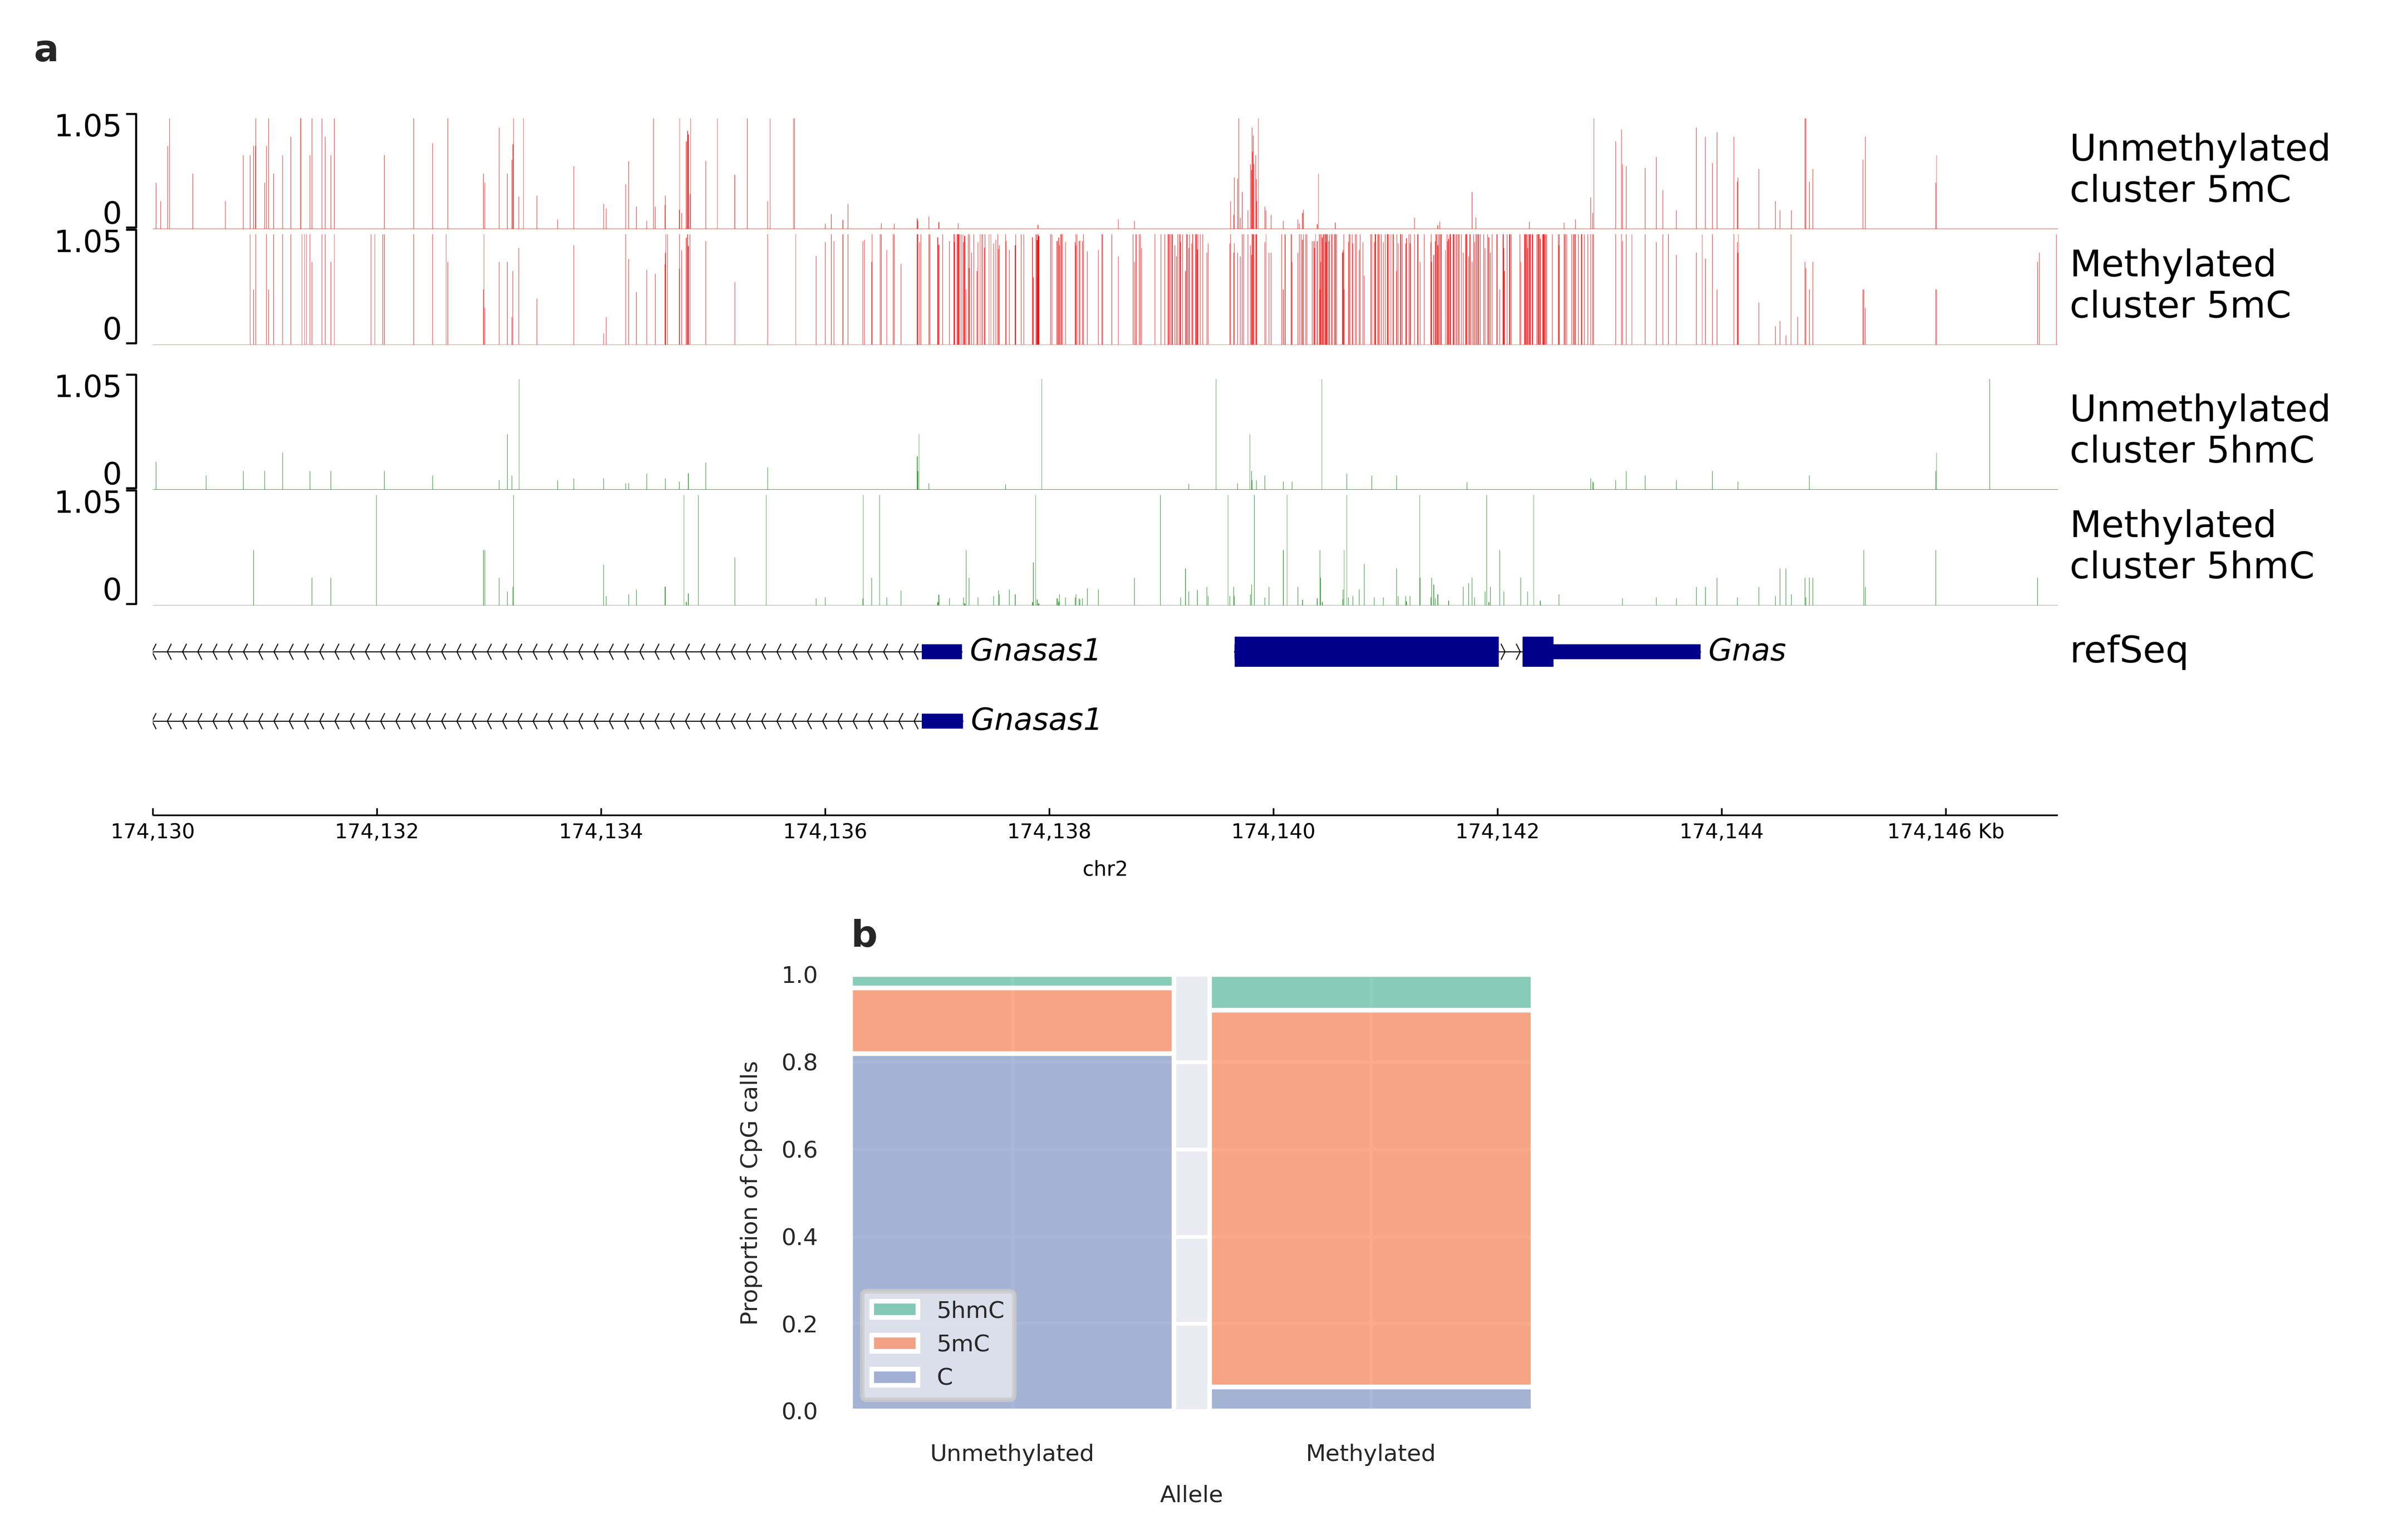

In [52]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid((3, 3), (2, 1))

# Panel 1 # 
im1 = plt.imread("./data_tables/DMR_analysis/output_images/Nespas-Gnasxl_PyGenomeTracks.png")
ax1.imshow(im1)
ax1.tick_params(axis="both", which="both", labelbottom=False, labelleft=False)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax1.grid(None)
# Panel 2 # 

# the alternative is two pie charts
sns.histplot(bar_df, x="Cluster", 
             hue="classification", multiple="fill", discrete=True, stat="proportion", shrink=0.9,
             common_norm=True, palette=sns.color_palette("Set2", 3), 
             hue_order=["5hmC", "5mC", "C"], ax=ax2)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.set_xticks([1, 2], ["Unmethylated", "Methylated"])
ax2.set_xlabel("Allele")
ax2.set_ylabel("Proportion of CpG calls")
ax2.get_legend().set_title(None)

plt.tight_layout()
plt.gcf().set_size_inches(180/25.4, 115/25.4)
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR_IP.png", dpi=600)

# hMeDIP analysis

In [2]:
import pandas as pd
import pyranges as pr
from common import *

ip_modbed = readModbam2bed("/mnt/data1/doh28/data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases_mapq60.bed", min_depth=0).dropna().rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start", 
    "chromEnd" : "End",
    "readCount" : "readCount_IP"
})

ip_peaks_file = pd.read_csv("../../data/cbm1_ip_13_07_23/quality_peaks.bedgraph", sep="\t", names=["Chromosome", "Start", "End", "peakDepth"])

ip_peaks_pr = pr.PyRanges(ip_peaks_file.query("peakDepth >= 6 & peakDepth <= 9"))

In [3]:
from MultisiteTools import featureRefPyRange

annotated_peaks = featureRefPyRange("./feature_references/genic/").join(ip_peaks_pr, how="right", 
                                                                        strandedness=False, apply_strand_suffix=False, 
                                                                        report_overlap=True, suffix="_Peak").as_df()

In [4]:
annotated_peaks_grouped = annotated_peaks.sort_values("Overlap", ascending=False).groupby(
    ["Chromosome", "Start_Peak", "End_Peak", "peakDepth"]).head(1).replace(
    {"-1" : "Intergenic",
     "3UTR" : "Exon",
     "5UTR" : "Exon"})
pie_labels = annotated_peaks_grouped["feature_type"].value_counts().index
pie_values = annotated_peaks_grouped["feature_type"].value_counts().values

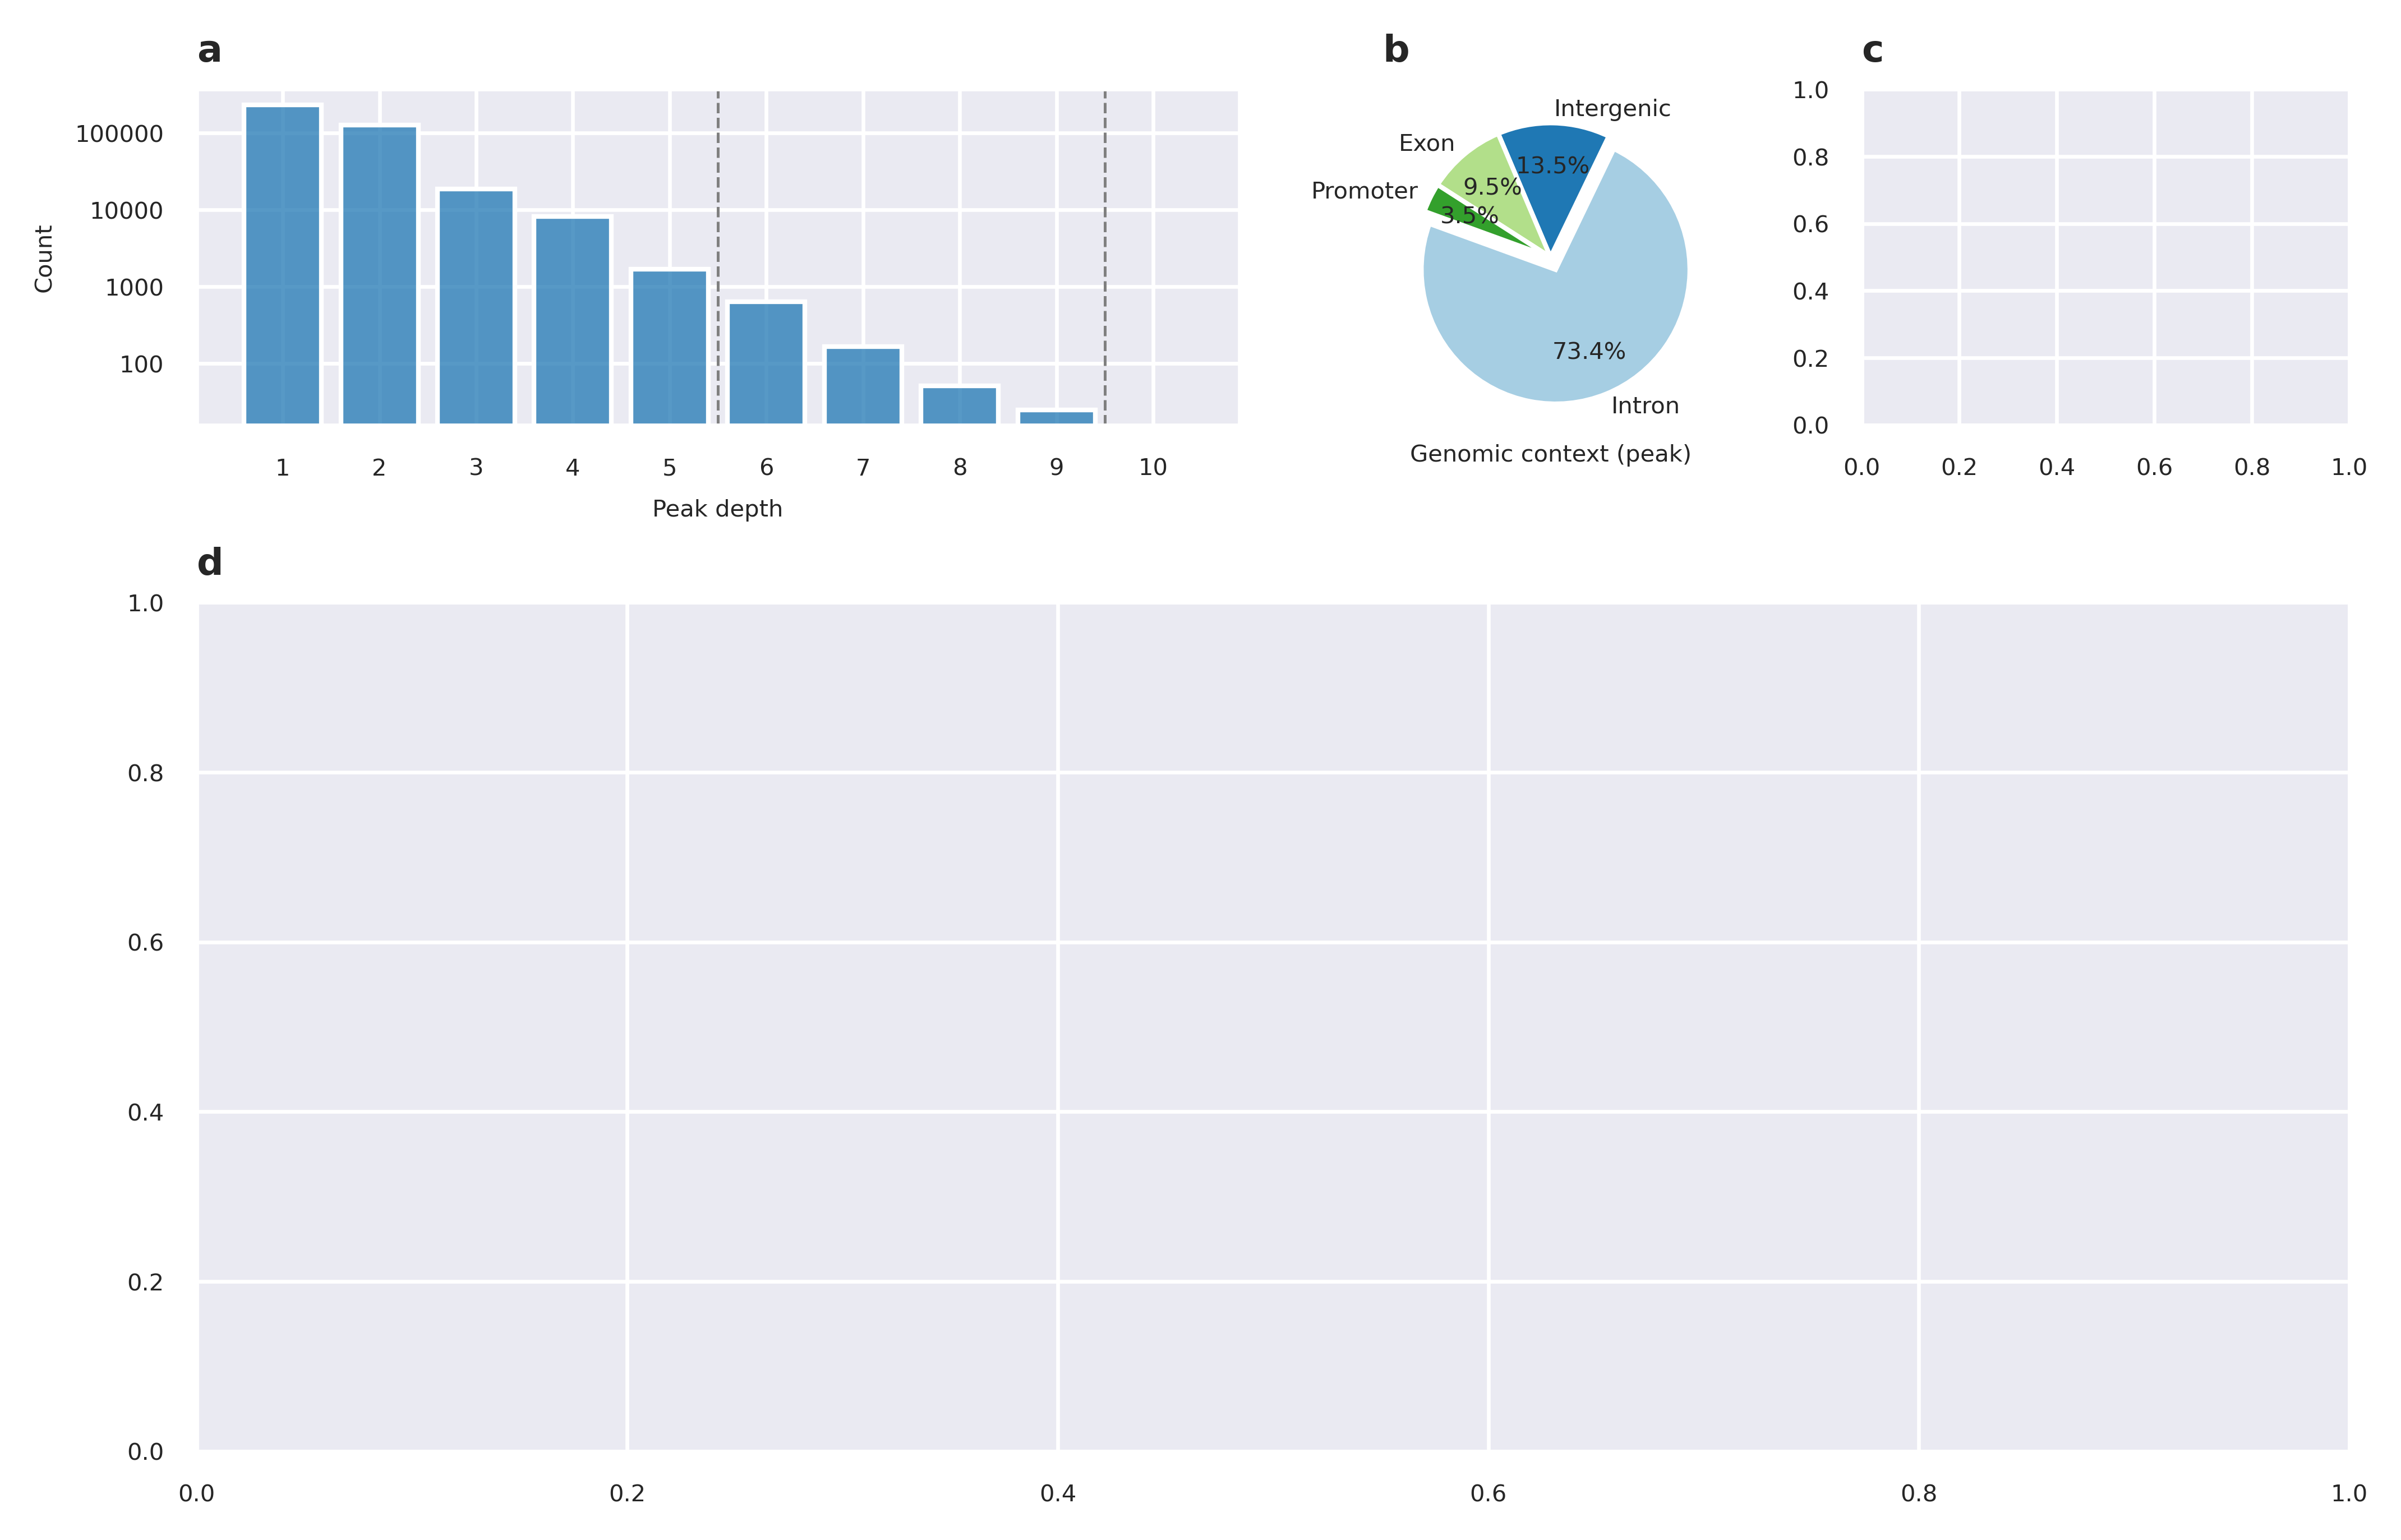

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(figsize=(180/25.4, 115/25.4), dpi=600)
sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 4), (0, 2))
ax3 = plt.subplot2grid((3, 4), (0, 3))
ax4 = plt.subplot2grid((3, 4), (1, 0), colspan=4, rowspan=2)

# Panel 1 # 

sns.histplot(ip_peaks_file, x="peakDepth", 
             binrange=(1, 10), discrete=True, shrink=0.8, log_scale=(False, True), element="bars", ax=ax1)
ax1.set_xticks(range(1, 11))
ax1.set_xlabel("Peak depth")
ax1.set_yscale("log")
ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.axvline(5.5, lw=0.6, ls="--", c="grey")
ax1.axvline(9.5, lw=0.6, ls="--", c="grey")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

# Panel 2 # 

ax2.pie(pie_values, labels=pie_labels, startangle=160, explode=(0.1, 0, 0, 0), colors=sns.color_palette("Paired", 4), autopct="%1.1f%%", pctdistance=0.67, labeldistance=1.1)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.set_xlabel("Genomic context (peak)")

ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")


plt.tight_layout()

In [103]:
prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

# renaming columns for compatability with PyRanges
prom_comp_data = prom_comp_data.rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start",
    "chromEnd" : "End"})

prom_comp_pr = CpGRange(prom_comp_data).unstrand()

with warnings.catch_warnings():
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(1000).enrichment_over_mean(include_zeros=True).df)

In [146]:
tiled_peak_df = ip_peaks_pr.join(tiles, suffix="_Tile").as_df().query("CpG_count > 3")

In [147]:
tiled_peak_merged = tiled_peak_df.groupby(["Chromosome", "Start_Tile", "End_Tile"], observed=True).agg(
    {"CpG_count" : "mean",
     "log2enrichment_5hmC_Nanopore" : "mean",
     "log2enrichment_5hmC_Bisulphite"  : "mean"}
).reset_index()

Is the sample enriched for 5hmC? It does *largely* align with regions that had more 5hmC in the original sample. 

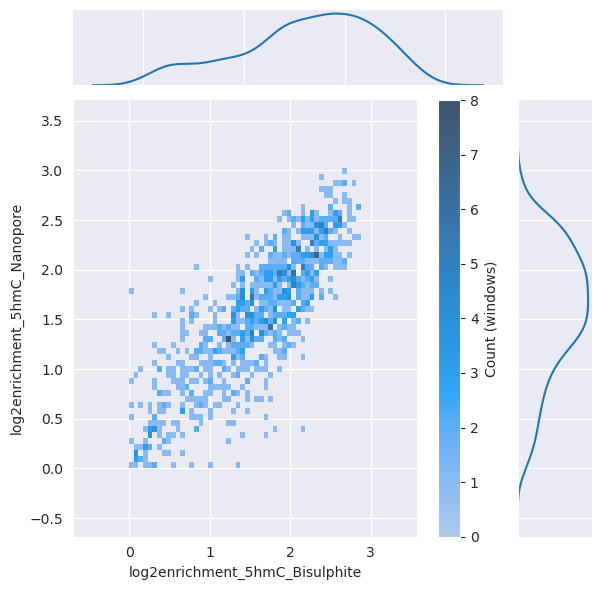

In [149]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("darkgrid")

jg = sns.JointGrid(tiled_peak_merged, x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore")

jg.plot_joint(sns.histplot, stat="count", cbar=True, cbar_kws={"label" : "Count (windows)"}, bins=50)
jg.plot_marginals(sns.kdeplot)

jg.set_axis_labels("")


In [ ]:
import pandas as pd
from MultisiteTools import *
import warnings
import pyranges as pr

ip_modbed = readModbam2bed("/mnt/data1/doh28/data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases_mapq60.bed", min_depth=0).dropna().rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start", 
    "chromEnd" : "End",
    "readCount" : "readCount_IP"
})

ip_peaks_file = pd.read_csv("../../data/cbm1_ip_13_07_23/quality_peaks.bedgraph", sep="\t", names=["Chromosome", "Start", "End", "peakDepth"]).query("peakDepth > 4")
ip_peaks_pr = pr.PyRanges(ip_peaks_file)

prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

# renaming columns for compatability with PyRanges
prom_comp_data = prom_comp_data.rename(columns={
    "chromosome" : "Chromosome",
    "chromStart" : "Start",
    "chromEnd" : "End"})

prom_comp_pr = CpGRange(prom_comp_data).unstrand()

with warnings.catch_warnings():
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(1000).enrichment_over_mean(include_zeros=True).df)

tiled_peak_df = ip_peaks_pr.join(tiles, suffix="_Tile").as_df().query("CpG_count > 3")
tiled_peak_merged = tiled_peak_df.groupby(["Chromosome", "Start_Tile", "End_Tile"], observed=True).agg(
    {"CpG_count" : "mean",
     "log2enrichment_5hmC_Nanopore" : "mean",
     "log2enrichment_5hmC_Bisulphite"  : "mean"}
).reset_index()

In [ ]:
# Panel 3 # 

div3 =  make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0)

sns.histplot(tiled_peak_merged, x="log2enrichment_5hmC_Bisulphite", y="log2enrichment_5hmC_Nanopore", 
             stat="count", cbar=True, cbar_ax=cax3, cbar_kws={"label" : "Count (peaks)"}, bins=50, ax=ax3)
ax3.set_aspect("equal")
ax3.set_xlabel("TAB enrichment score")
ax3.set_ylabel("Nanopore\nenrichment score")
ax3.set_xticks(np.arange(0, 3.5, 0.5))
ax3.set_yticks(np.arange(0, 3.5, 0.5))
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 # 

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
